#Segmentación de Imágenes Satelitales con Aprendizaje Profundo
##Introducción
Este cuaderno demuestra el proceso de adquisición, preprocesamiento y segmentación de imágenes satelitales utilizando técnicas de aprendizaje profundo. La imaginería satelital es una fuente crucial de datos para diversas aplicaciones ambientales y tecnológicas, como el monitoreo de cambios en el agua superficial, la deforestación, el crecimiento urbano, y más.

En este tutorial, utilizaremos bibliotecas de Python como TensorFlow, Keras y scikit-image para procesar imágenes satelitales y desarrollar un modelo simple de segmentación. Los pasos clave incluyen:

- Adquisición de Datos: Descargar una imagen satelital de muestra y entender su formato.
Preprocesamiento: Normalizar los datos de la imagen y crear etiquetas para la segmentación.
- Parches de Imágenes: Crear múltiples parches de la imagen para aumentar el número de muestras para el entrenamiento.
- Entrenamiento del Modelo: Construir y entrenar una red neuronal convolucional (CNN) para realizar la segmentación de imágenes.
- Evaluación del Modelo: Evaluar el rendimiento del modelo en datos de prueba.

##Paso 1: Instalar Bibliotecas Necesarias
En la primera celda de tu cuaderno, instala las bibliotecas necesarias ejecutando el siguiente código:

In [1]:
!pip install numpy pandas matplotlib
!pip install rasterio geopandas scikit-image
!pip install tensorflow keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 37.1 MB/s eta 0:00:00


##Paso 2: Importar las Bibliotecas
En una nueva celda, importa las bibliotecas que usarás:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import geopandas as gpd
from skimage import io
import tensorflow as tf
from tensorflow import keras

##Paso 3: Adquirir Datos
Para este ejemplo, vamos a usar una imagen PNG. Aquí hay un enlace para descargar una imagen de ejemplo:

In [7]:
!wget https://upload.wikimedia.org/wikipedia/commons/4/47/PNG_transparency_demonstration_1.png -O sentinel_image.png

--2024-05-31 21:16:19--  https://upload.wikimedia.org/wikipedia/commons/4/47/PNG_transparency_demonstration_1.png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 226933 (222K) [image/png]
Saving to: ‘sentinel_image.png’

sentinel_image.png  100%[===================>] 221.61K  --.-KB/s    in 0.07s   

2024-05-31 21:16:20 (3.27 MB/s) - ‘sentinel_image.png’ saved [226933/226933]



##Paso 4: Leer y Visualizar la Imagen
Usa skimage.io para leer la imagen:

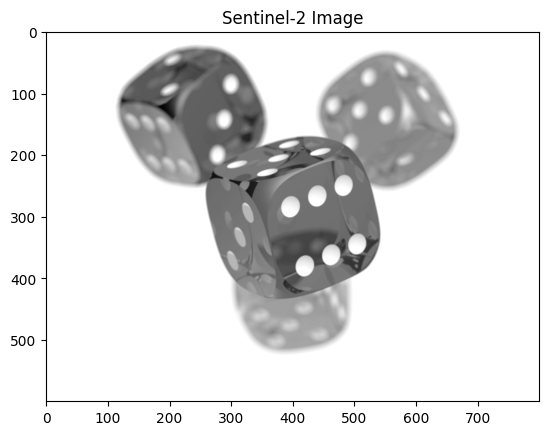

In [8]:
image_path = 'sentinel_image.png'
image = io.imread(image_path, as_gray=True)
plt.imshow(image, cmap='gray')
plt.title("Sentinel-2 Image")
plt.show()

##Paso 5: Preprocesar la Imagen
Normaliza la imagen para que los valores estén entre 0 y 1:

In [10]:
image = image.astype('float32') / 255.0

##Paso 6: Crear Etiquetas (Simulación)
Para este ejemplo, crearemos etiquetas simuladas. Normalmente, tendrías datos de etiquetas reales.

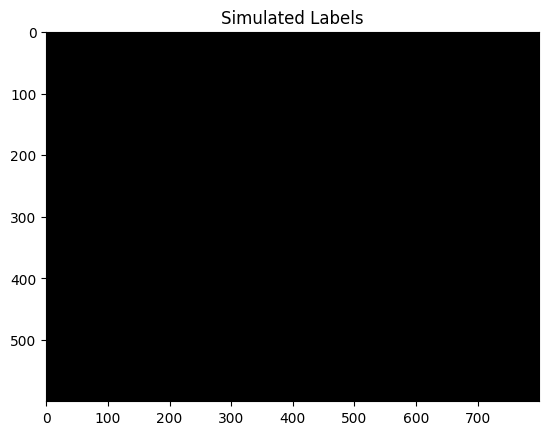

In [11]:
labels = (image > 0.5).astype(int)
plt.imshow(labels, cmap='gray')
plt.title('Simulated Labels')
plt.show()

##Paso 7: Crear Patches y Dividir Datos en Entrenamiento y Prueba
Vamos a crear recortes (patches) de la imagen para aumentar el número de muestras y luego dividirlos en conjuntos de entrenamiento y prueba.

###Crear Patches de la Imagen

In [13]:
from sklearn.feature_extraction.image import extract_patches_2d

# Definir el tamaño de los patches
patch_size = (64, 64)

# Extraer patches de la imagen y las etiquetas
image_patches = extract_patches_2d(image, patch_size, max_patches=500, random_state=42)
label_patches = extract_patches_2d(labels, patch_size, max_patches=500, random_state=42)

# Asegurarnos de que los patches tienen la forma correcta para Keras
image_patches = image_patches.reshape(-1, patch_size[0], patch_size[1], 1)
label_patches = label_patches.reshape(-1, patch_size[0], patch_size[1], 1)

print(f'Number of patches: {image_patches.shape[0]}')

Number of patches: 500


###Dividir los Patches en Conjuntos de Entrenamiento y Prueba

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_patches, label_patches, test_size=0.2, random_state=42)

##Paso 8: Crear y Entrenar el Modelo
Crea un modelo de segmentación simple usando Keras:

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(patch_size[0], patch_size[1], 1)),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(1, (3, 3), activation='sigmoid', padding='same')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 up_sampling2d (UpSampling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                        

##Paso 9: Evaluar el Modelo
Evalúa el modelo en los datos de prueba:

In [16]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Loss: {loss}')
print(f'Model Accuracy: {accuracy}')

4/4 [==============================] - 1s 105ms/step - loss: 2.7691e-05 - accuracy: 1.0000
Model Loss: 2.7690753995557316e-05
Model Accuracy: 1.0
